In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path

In [3]:
path = Path.cwd().parent / 'data' / 'base'

In [4]:
bids = []
offers = []
pns = []

for d in tqdm(os.listdir(path)):

    try:
        bids.append(
            pd.read_csv(path / d / 'bids.csv', index_col=[0,1]
            )
        )
    except FileNotFoundError:
        pass

    try:
        offers.append(
            pd.read_csv(path / d / 'offers.csv', index_col=[0,1]
            )
        )
    except FileNotFoundError:
        pass

    try:
        pns.append(
            pd.read_csv(path / d / 'physical_notifications.csv', index_col=0
            )
        )
    except FileNotFoundError:
        pass

offers = pd.concat(offers)
bids = pd.concat(bids)
pns = pd.concat(pns)


100%|██████████| 851/851 [01:58<00:00,  7.21it/s]


In [6]:
onwind_farms = [
    'TMNCW-1',
    'BLARW-1',
    'BRDUW-1',
    'GRGRW-1',
    'CREAW-1',
    'CUMHW-1',
    'DALQW-1',
    'FAARW-1',
    'FAARW-2',
    'GLNKW-1',
    'KENNW-1',
    'KLGLW-1',
    'KYPEW-1',
    'SAKNW-1',
    'PNYCW-1',
    'SOKYW-1',
    ]

offwind_farms = [
    'BLLA-1',
    'BLLA-2',
]

carrier_mapper = {
    'offwind': ['offwind', 'floating wind'],
    'onwind': ['onwind'],
    'biomass': ['biomass'],
    'fossil': ['gas', 'gas-fired', 'gas turbine', 'CCGT', 'powerstation', 'CHP', 'coal', 'oil'],
    'demand_flex': ['supply', 'natural gas processing'],
    'PHS': ['PHS'],
    'battery': ['battery'],
    'solar': ['solar', 'solar power station', 'PV'],
    'nuclear': ['nuclear'],
    'hydro': ['cascade', 'dam', 'hydro', 'hydro-scheme'],
    'load': ['submarine power cable', 'steel mill'],
    'interconnector': ['interconnector', 'HVDC submarine'],
}

In [7]:
old = pd.read_csv(Path.cwd().parent / 'data' / 'bmunits_loc.csv', index_col=0)

In [8]:
supply = old.loc[old.carrier == 'supply'].index

In [10]:
bmus = pd.read_csv(Path.cwd().parent / 'data' / 'temp_located_bmus.csv', index_col=0).dropna()

bmus = pd.concat([bmus] + [
    pd.DataFrame({
            'lon': ['distributed'] * len(supply),
            'lat': ['distributed'] * len(supply),
            'capacity': [0.] * len(supply),
            'carrier': ['supply'] * len(supply),
            }, index=supply)
])

bmus.loc[bmus.carrier == 'supply']
# bmus = bmus.loc[bmus['lon'] != 0.]

bmus.loc[onwind_farms, 'carrier'] = 'onwind'
bmus.loc[offwind_farms, 'carrier'] = 'offwind'

for clean_name, old_carriers in carrier_mapper.items():
    bmus.loc[bmus['carrier'].isin(old_carriers), 'carrier'] = clean_name

dflex_index = bmus.loc[bmus.carrier == 'demand_flex'].index
bmus.loc[dflex_index, ['lat', 'lon']] = 'distributed'

bmus = bmus[~bmus.index.duplicated(keep='first')]



In [11]:
hydro = bmus.loc[bmus.carrier == 'hydro'].index

cas = hydro[hydro.str.contains('CAS')].to_list() + ['LCSMH-1']
non_cas = hydro[~hydro.str.contains('CAS')].to_list()

print('CAS:', cas)
print('non-CAS:', non_cas)

CAS: ['CAS-BEU01', 'CAS-CLU01', 'CAS-CON01', 'CAS-GAR01', 'CAS-KIL01', 'CAS-MOR01', 'LCSMH-1']
non-CAS: ['NSC-ATL01', 'LCSMH-1', 'KNLCV-1', 'CLAC-1', 'FASN3', 'FASN-4', 'RHEI-4', 'SLOY-1', 'SLOY-4', 'ERRO-1', 'ERRO-2', 'ERRO-3', 'FASN-1', 'FASN2', 'FINL-1', 'GLNDO-1', 'NANT-1', 'SLOY-2', 'SLOY-3']


In [12]:
bmus.loc[cas, 'carrier'] = 'cascade'

In [13]:
bmus.carrier.value_counts()

carrier
interconnector    628
fossil            120
onwind            114
offwind            79
battery            67
nuclear            23
hydro              18
PHS                17
biomass             9
demand_flex         8
cascade             7
load                3
solar               2
business            1
Name: count, dtype: int64

In [14]:
bmus.loc[bmus.carrier == 'demand_flex']

,lat,lon,capacity,carrier
NationalGridBmUnit,,,,
CASKD-1,distributed,distributed,0.0,demand_flex
SFGSD-1,distributed,distributed,0.0,demand_flex
SFGSD-2,distributed,distributed,0.0,demand_flex
SFERD-1,distributed,distributed,0.0,demand_flex
EAS-SEL01,distributed,distributed,0.0,demand_flex
SEE-PGU01,distributed,distributed,0.0,demand_flex
YEP-ATL01,distributed,distributed,0.0,demand_flex
YEP-PGU01,distributed,distributed,0.0,demand_flex


In [15]:
# bmus = pd.read_csv(Path.cwd().parent / 'data' / 'bmunits_loc.csv', index_col=0).dropna()

bmus.loc[(bmus.carrier == 'battery') & (bmus['lon'] == 0.)].shape
missing_batteries = bmus.loc[(bmus.carrier == 'battery') & (bmus['lon'] == 0.)].index

pns.loc[:, missing_batteries].abs().sum().sort_values(ascending=False)

NationalGridBmUnit
DOLLB-1      228537.300000
AG-HLIM03    188793.900000
AG-MSTK01    185430.633333
PILLB-1      176946.933333
PILLB-2      169000.833333
SKELB-1      163604.666667
BURWB-1      155574.266667
AG-HEL00G    153510.950000
AG-HLIM04    150928.966667
KEMB-1       128571.466667
AG-MFLX02    125605.116667
BUSTB-1      122505.500000
AG-HSTK02    115759.383333
COVNB-1      114946.150000
AG-HSTK01    114793.333333
CLAYB-1      114580.766667
AG-ASTK05    108677.933333
BFSE01       108425.850000
TOLLB-1      106604.000000
ILMEB-1      105801.566667
CLAYB-2      102936.033333
ARNKB-1       98380.700000
LITRB-1       96368.533333
THMRB-1       93618.300000
CUPAB-1       92328.966667
AG-PFLX01     71119.533333
AG-ZEN03J     66753.900000
NFSE02        59019.200000
FARNB-1       58183.966667
AG-LLIM01     55247.200000
JAMBB-1       50482.366667
AG-HLIM02     48901.766667
AG-GEDF01     44691.433333
AG-GEDF02     44581.116667
ZEN02A        42333.300000
BHOLB-1       31219.000000
BROAB-1  

In [16]:
def search_similar(name, df):
    return df.loc[df.index.str.contains(name, case=False)]

search_similar('WBURB', bmus)

,lat,lon,capacity,carrier
NationalGridBmUnit,,,,
WBURB-1,53.363665,-0.53833,1332.0,fossil
WBURB-2,53.363665,-0.53833,1332.0,fossil
WBURB-3,53.363665,-0.53833,1332.0,fossil
WBURB-41,0.0,0.0,49.0,battery
WBURB-43,0.0,0.0,49.0,battery


In [17]:
manual_battery_locs = {
    'RSCRB-1': ('distributed', 'distributed'),
    'PNYCB-1': (51.709, -3.564),
    'ARNKB-2': (51.484, 0.344),
    'AG-HEL0DN': (56.166, -3.204),
    'WBURB-41': (53.364, -0.538),
    'WBURB-43': (53.364, -0.538),
    'CRSSB-1': (53.481, -2.959),
    'AG-HEL0CP': (56.324, -2.995),
    'AG-HLIM01': (56.941, -2.255),
    'AG-JSTK02': (51.231, -0.334),
    'NEWTB-1': (53.138, -1.327),
    'FFSE01': (55.016, -1.473),
    'BROAB-1': (51.413, 0.33),
    'BHOLB-1': (50.721, -1.998),
    'ZEN02A': (52.07, 0.591),
    'AG-GEDF01': (53.197, -2.254),
    'AG-GEDF02': (53.197, -2.254),
    'AG-HLIM02': (50.852, -1.194),
    'JAMBB-1': (56.341, -3.294),
    'BFSE01': (52.585, -1.22),
    'DOLLB-1': (51.6, 0.56),
    'AG-HLIM03': (51.616, -1.99),
    'AG-MSTK01': (53.791, -0.405),
    'PILLB-1': (53.796, -0.407),
    'PILLB-2': (53.796, -0.407),
    'SKELB-1': (53.553, -2.775),
    'BURWB-1': (52.279, 0.316),
    'AG-HEL00G': (53.787, -2.643),
    'AG-HLIM04': (51.598, -1.494),
    'AG-HLIM01': (51.598, -1.494),
    'KEMB-1': (51.364, 0.737),
    'AG-MFLX02': (53.398, -1.247),
    'BUSTB-1': (52.549, -2.02),
    'AG-HSTK02': (51.615, -1.962),
    'COVNB-1': (52.409, -1.508),
    'AG-HSTK01': (51.615, -1.962),
    'CLAYB-1': (51.552, 0.298),
    'CLAYB-2': (51.552, 0.298),
    'AG-ASTK05': (52.197, 0.126),
    'TOLLB-1': (51.735, -0.245),
    'ILMEB-1': (51.741, -0.892),
    'ARNKB-1': (52.61, -2.),
    'LITRB-1': (56.104, -3.33),
    'THMRB-1': (51.766, -0.894),
    'CUPAB-1': (56.316, -3.013),
    'AG-PFLX01': (56.412, -3.423),
    'AG-ZEN03J': (51.302, 0.477),
    'NFSE02': (55.907, -3.588),
    'FARNB-1': (51.21, -0.791),
    'AG-LLIM01': (51.516, -2.652),
    'BARNB-1': (53.558, -1.457),
}

In [18]:
bmus.loc[bmus.isna().any(axis=1)]

,lat,lon,capacity,carrier
NationalGridBmUnit,,,,


In [19]:
for name, loc in manual_battery_locs.items():
    bmus.loc[name, ['lat', 'lon']] = loc

bmus.loc['RSCRB-1', 'carrier'] = 'demand_flex'

In [20]:
bmus.loc[(bmus.carrier == 'battery') & (bmus['lon'] == 0.)].shape
missing_batteries = bmus.loc[(bmus.carrier == 'battery') & (bmus['lon'] == 0.)].index

pns.loc[:, missing_batteries].abs().sum().sort_values(ascending=False)

Series([], dtype: float64)

In [21]:
import geopandas as gpd

clean = bmus.loc[bmus['lat'] != 0]

In [22]:
clean.loc['CASKD-1']

lat         distributed
lon         distributed
capacity            0.0
carrier     demand_flex
Name: CASKD-1, dtype: object

<Axes: >

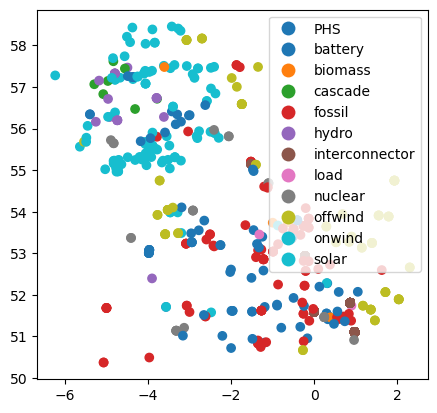

In [23]:

gpd.GeoDataFrame(
    clean.loc[clean.carrier != 'demand_flex'],
    # {'carrier': clean.carrier},
    # index=clean.loc[clean.carrier != 'demand_flex'].index,
    geometry=gpd.points_from_xy(
        clean.loc[clean.carrier != 'demand_flex']['lon'],
        clean.loc[clean.carrier != 'demand_flex']['lat']
    )
).plot(column='carrier', legend=True)

In [24]:
# clean = bmus.loc[bmus['lat'] != 0]
clean = bmus
clean.loc[clean.carrier == 'demand_flex']

,lat,lon,capacity,carrier
NationalGridBmUnit,,,,
RSCRB-1,distributed,distributed,0.0,demand_flex
CASKD-1,distributed,distributed,0.0,demand_flex
SFGSD-1,distributed,distributed,0.0,demand_flex
SFGSD-2,distributed,distributed,0.0,demand_flex
SFERD-1,distributed,distributed,0.0,demand_flex
EAS-SEL01,distributed,distributed,0.0,demand_flex
SEE-PGU01,distributed,distributed,0.0,demand_flex
YEP-ATL01,distributed,distributed,0.0,demand_flex
YEP-PGU01,distributed,distributed,0.0,demand_flex


In [27]:
bmus.loc[bmus['lon'] != 0].to_csv(Path.cwd().parent / 'data' / 'bmus_prepared.csv')

In [95]:
bmus.loc[bmus.carrier == 'business']

,lat,lon,capacity,carrier
NationalGridBmUnit,,,,
ANGLD-1,0.0,0.0,0.0,business


<Axes: >

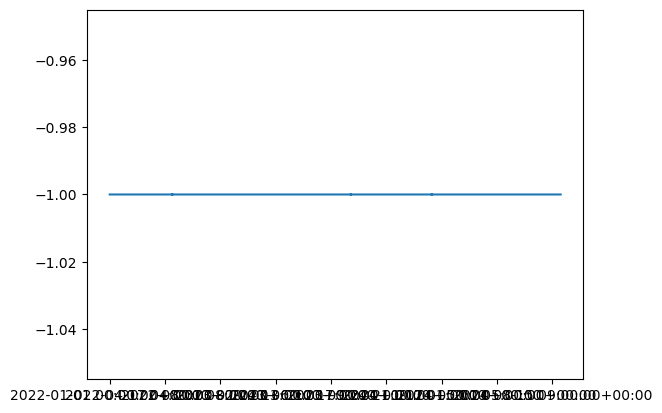

In [97]:
pns['ANGLD-1'].plot()

100


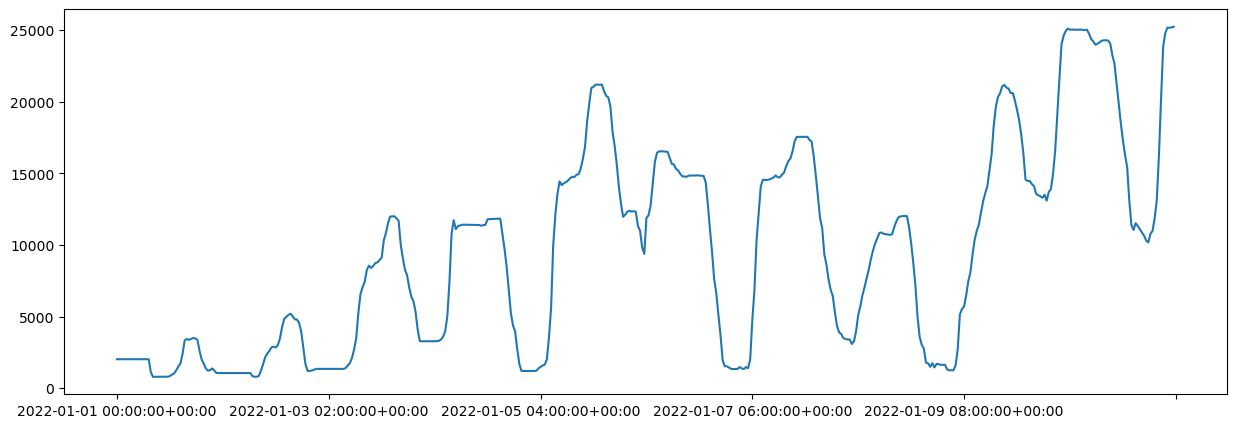

In [124]:
import matplotlib.pyplot as plt

carrier = 'fossil'

b = bmus.loc[bmus.carrier == carrier].index
print(len(b))

fig, ax = plt.subplots(figsize=(15, 5))

pns.loc[:,b].sum(axis=1).iloc[:500].plot(ax=ax)
# pns.loc[:,b].iloc[5000:10000].plot(ax=ax)

plt.show()

In [93]:
import geopandas as gpd

countries = gpd.read_file('country_shapes.geojson').set_index('cntry_name')

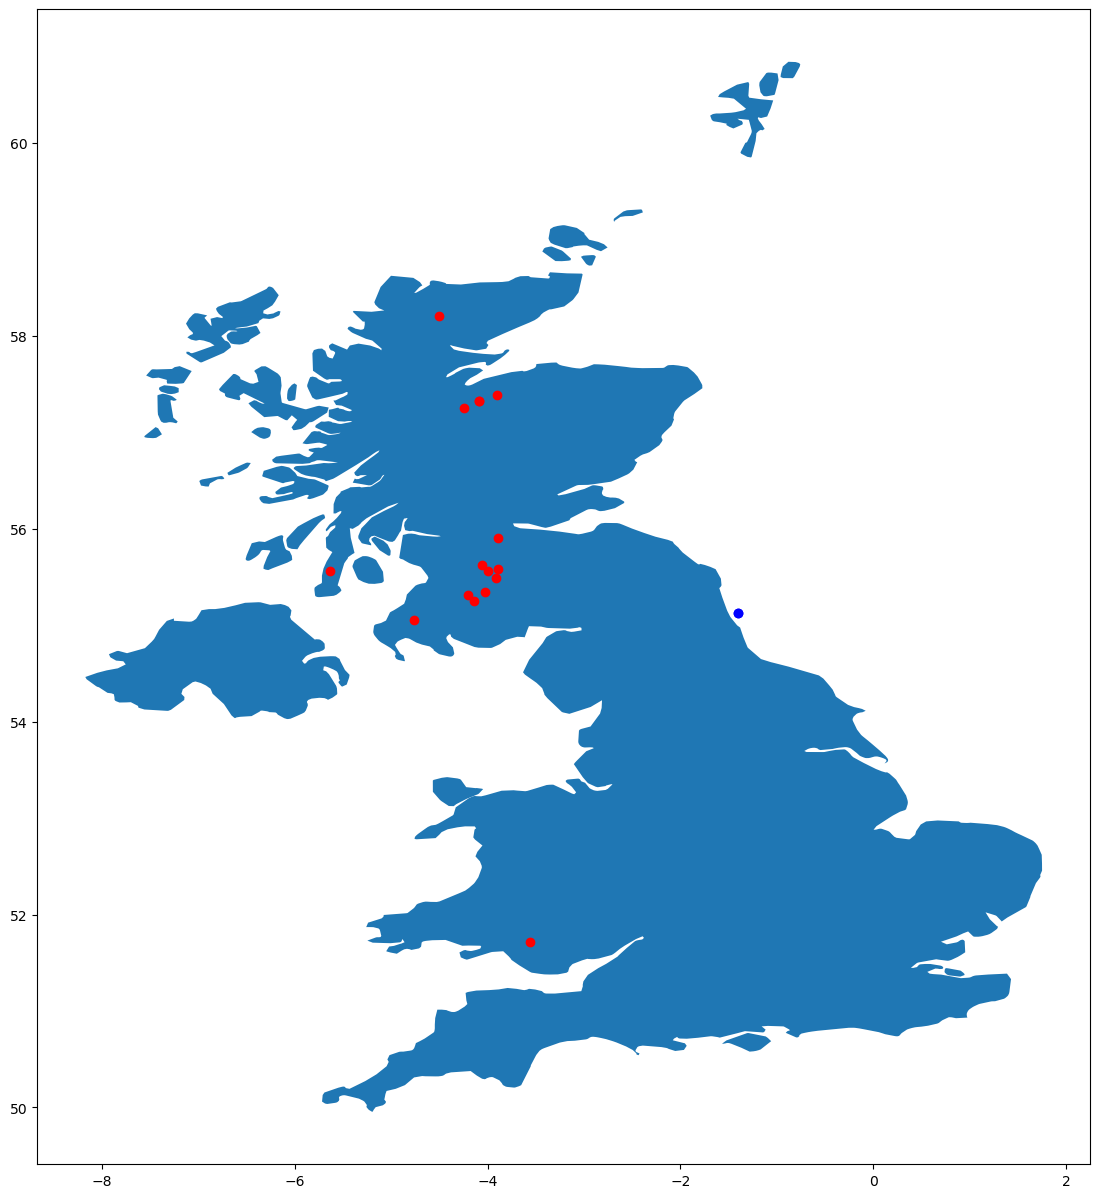

In [102]:
# countries.loc[['United Kingdom']].plot()
wind = bmus.loc[bmus.carrier == 'wind']
wind = gpd.GeoDataFrame(wind, geometry=gpd.points_from_xy(wind.lon, wind.lat))

onwind = wind.loc[wind['geometry'].within(countries.loc['United Kingdom'].geometry)]
offwind = wind.loc[~wind['geometry'].within(countries.loc['United Kingdom'].geometry)]

fig, ax = plt.subplots(figsize=(15, 15))

countries.loc[['United Kingdom']].plot(ax=ax)
onwind.plot(ax=ax, color='red')
offwind.plot(ax=ax, color='blue')
plt.show()

In [23]:
bmus.loc[bmus.carrier == 'battery'].head(30)

,lat,lon,capacity,carrier
NationalGridBmUnit,,,,
BFSE01,0.000000,0.000000,50.0,battery
RSCRB-1,0.000000,0.000000,0.0,battery
AG-HLIM01,0.000000,0.000000,60.0,battery
AG-HLIM02,0.000000,0.000000,60.0,battery
AG-HLIM03,0.000000,0.000000,100.0,battery
AG-HLIM04,0.000000,0.000000,100.0,battery
AG-MFLX02,0.000000,0.000000,50.0,battery
AG-PFLX01,0.000000,0.000000,49.9,battery
ARNKB-2,0.000000,0.000000,49.9,battery


In [19]:
import pypsa
import numpy as np
import pandas as pd

n = pypsa.Network()
s = [1,2,3,4]

n.set_snapshots(s)

n.add("Bus", "bus")
n.add("Bus", "bus2")

forced_flow = pd.Series(np.linspace(-1, 1, len(s)), index=s)

n.add(
    "Generator",
    "gen",
    bus="bus",
    carrier="tech1",
    p_nom=2,
    marginal_cost=1
    )

n.add(
    "Generator",
    "gen2",
    bus="bus2",
    carrier="tech2",
    p_nom=2,
    marginal_cost=0,
    )

n.add(
    "Load",
    "load",
    bus="bus",
    p_set=1
    )
n.add(
    "Load",
    "load2",
    bus="bus2",
    p_set=1
    )

print(forced_flow)
n.add(
    "Link",
    "link",
    bus0="bus2",
    bus1="bus",
    p_nom=1,
    p_set=forced_flow,
    p_min_pu=-1,
    p_max_pu=1,
)

n.optimize()

Index(['bus', 'bus2'], dtype='object', name='Bus')
Index(['link'], dtype='object', name='Link')


1   -1.000000
2   -0.333333
3    0.333333
4    1.000000
dtype: float64


Index(['gen', 'gen2'], dtype='object', name='Generator')
Index(['bus', 'bus2'], dtype='object', name='Bus')
Index(['link'], dtype='object', name='Link')
Index(['gen', 'gen2'], dtype='object', name='Generator')
c:\Users\lukas\miniforge3\envs\pypsa-eur\Lib\site-packages\linopy\common.py:147: UserWarning: coords for dimension(s) ['Generator'] is not aligned with the pandas object. Previously, the indexes of the pandas were ignored and overwritten in these cases. Now, the pandas object's coordinates are taken considered for alignment.
  warn(
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.09s
INFO:linopy.solvers:Log file at C:\Users\lukas\AppData\Local\Temp\highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 12 primals, 38 duals
Objective: 4.00e+00
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generat

('ok', 'optimal')

In [4]:
n.generators_t.p

Generator,gen,gen2
snapshot,,
now,0.5,0.5
